# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Основные шаги:
- Загрузим и изучим данные
- Заполним пропущенные значения и обработаем аномалии в столбцах. Удалим неинформативные
- Подготовим выборки для обучения моделей.
- Обучим три модели: LGBMRegressor, CatBoostRegressor, RandomForestRegressor. Для каждой модели попробуем разные гиперпараметры.
- Проанализируем время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберем лучшую модель и проверим её качество на тестовой выборке.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

#np.random.seed(12345)

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


Целевой признак
- Price — цена (евро)

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


 Все количественные параметры заполнены - пропущены только категориальные переменные

In [4]:
#Оценим количество пропущенных значений
print(df.isna().sum())
print("Доля строк без пропусков:",df.dropna().shape[0]/df.shape[0])

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
Доля строк без пропусков: 0.6936667710776055


Если удалим все пропуски, потеряем треть данных :(

Ок, заменим все пропуски на 'no_data'

In [5]:
df['NotRepaired'] = df['NotRepaired'].fillna('no_data')
df['Model'] = df['Model'].fillna('no_data')
df['VehicleType'] = df['VehicleType'].fillna('no_data')
df['FuelType'] = df['FuelType'].fillna('no_data')
df['Gearbox'] = df['Gearbox'].fillna('no_data')

In [6]:
#Эти данные ничего не дадут анализу - удаляем
df = df.drop(['DateCrawled','DateCreated','LastSeen','RegistrationMonth'],axis = 1)

In [7]:
df['NumberOfPictures'].describe() #Количество картинок у всех нулевое - удалим столбец
df = df.drop('NumberOfPictures',axis = 1)

In [8]:
print('VehicleType',df['VehicleType'].unique())
print('Gearbox',df['Gearbox'].unique())
print('Model',df['Model'].unique())
print('FuelType',df['FuelType'].unique())
print('Brand',df['Brand'].unique())
print('NotRepaired',df['NotRepaired'].unique())

VehicleType ['no_data' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']
Gearbox ['manual' 'auto' 'no_data']
Model ['golf' 'no_data' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'loga

Дополнительно унифицировать категориальные данные не получится - нет идей

Посмотрим на количественные данные и очистим от выбросов и мусора

In [9]:
df = df.drop(df.loc[df['RegistrationYear']>2016].index)
df = df.drop(df.loc[df['RegistrationYear']<1980].index)
df = df.drop(df.loc[df['Power']>400].index)
df = df.drop(df.loc[df['Power']<80].index) #как минимум для безопасной перевозки 4 взрослых в машине минимальная мощность составит около 80 лошадиных сил.
df = df.drop(df.loc[df['Price']<1000].index)#примем, что авто ниже 1к евро - металлолом

not numeric type VehicleType
not numeric type Gearbox
not numeric type Model
not numeric type FuelType
not numeric type Brand
not numeric type NotRepaired


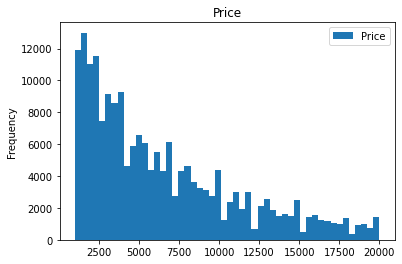

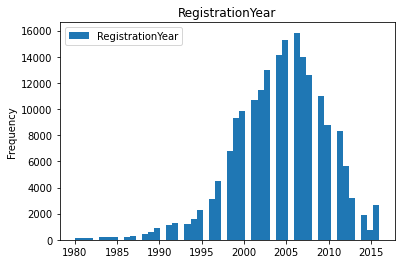

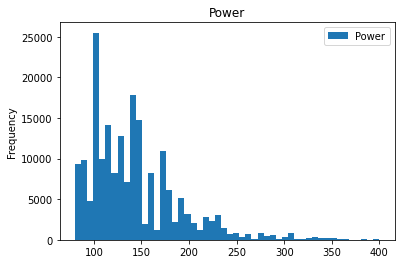

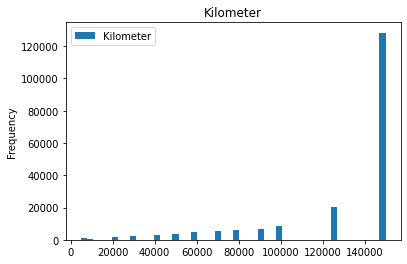

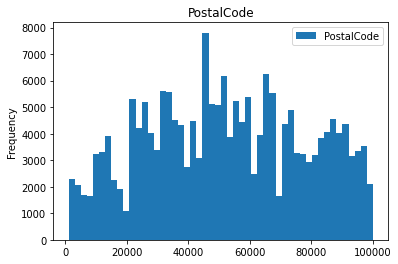

In [10]:
for i in df:
    try:
        df.plot(y = i,title = i,kind = 'hist', bins = 50)
    except:
        print('not numeric type',i)

In [11]:
#Проведем корреляционный анализ данных
df.corr()

,Price,RegistrationYear,Power,Kilometer,PostalCode
Price,1.000000,0.577559,0.381447,-0.449913,0.051756
RegistrationYear,0.577559,1.000000,-0.014664,-0.406885,0.017660
Power,0.381447,-0.014664,1.000000,0.128399,0.029284
Kilometer,-0.449913,-0.406885,0.128399,1.000000,-0.014530
PostalCode,0.051756,0.017660,0.029284,-0.014530,1.000000


In [12]:
#Удалим дубликаты
print(df.duplicated().sum())
df = df.drop_duplicates()

14233


In [13]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
1,18300,coupe,2011,manual,190,no_data,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no_data,90480
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,67112
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no_data,94505
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no,96224


Ок, связи между данными слабые, наиболее сильная - между годом регистрации авто и ценой

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179612 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             179612 non-null  int64 
 1   VehicleType       179612 non-null  object
 2   RegistrationYear  179612 non-null  int64 
 3   Gearbox           179612 non-null  object
 4   Power             179612 non-null  int64 
 5   Model             179612 non-null  object
 6   Kilometer         179612 non-null  int64 
 7   FuelType          179612 non-null  object
 8   Brand             179612 non-null  object
 9   NotRepaired       179612 non-null  object
 10  PostalCode        179612 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 16.4+ MB


При очистке потеряли треть данных все-таки :/

## Обучение моделей

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179612 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             179612 non-null  int64 
 1   VehicleType       179612 non-null  object
 2   RegistrationYear  179612 non-null  int64 
 3   Gearbox           179612 non-null  object
 4   Power             179612 non-null  int64 
 5   Model             179612 non-null  object
 6   Kilometer         179612 non-null  int64 
 7   FuelType          179612 non-null  object
 8   Brand             179612 non-null  object
 9   NotRepaired       179612 non-null  object
 10  PostalCode        179612 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 16.4+ MB


In [16]:
#разделим выборку на тестовую, обучающую и валидационную
features_train, features_valid, target_train, target_valid = train_test_split(
    df.drop('Price', axis=1), df['Price'], test_size=0.40, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345)

In [17]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107767 entries, 263856 to 146341
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       107767 non-null  object
 1   RegistrationYear  107767 non-null  int64 
 2   Gearbox           107767 non-null  object
 3   Power             107767 non-null  int64 
 4   Model             107767 non-null  object
 5   Kilometer         107767 non-null  int64 
 6   FuelType          107767 non-null  object
 7   Brand             107767 non-null  object
 8   NotRepaired       107767 non-null  object
 9   PostalCode        107767 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 9.0+ MB


In [18]:
features_test.info() #тут все ок

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35922 entries, 255931 to 217901
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   VehicleType       35922 non-null  object
 1   RegistrationYear  35922 non-null  int64 
 2   Gearbox           35922 non-null  object
 3   Power             35922 non-null  int64 
 4   Model             35922 non-null  object
 5   Kilometer         35922 non-null  int64 
 6   FuelType          35922 non-null  object
 7   Brand             35922 non-null  object
 8   NotRepaired       35922 non-null  object
 9   PostalCode        35922 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 3.0+ MB


In [19]:
features_valid.info()  #тут все ок

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35923 entries, 213636 to 119600
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   VehicleType       35923 non-null  object
 1   RegistrationYear  35923 non-null  int64 
 2   Gearbox           35923 non-null  object
 3   Power             35923 non-null  int64 
 4   Model             35923 non-null  object
 5   Kilometer         35923 non-null  int64 
 6   FuelType          35923 non-null  object
 7   Brand             35923 non-null  object
 8   NotRepaired       35923 non-null  object
 9   PostalCode        35923 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 3.0+ MB


In [20]:
#Из-за обсузовавшихся в features_train дыр мы не можем кодировать данные после разбиения, поэтому кодируем "до"
cat_col = ['VehicleType', 'Gearbox', 'Model','FuelType', 'Brand', 'NotRepaired']
encoder = OrdinalEncoder()

df_ordinal = df.copy()
encoder.fit(df_ordinal[cat_col])
df_ordinal[cat_col] = encoder.transform(df_ordinal[cat_col])

In [21]:
#разделим закодированную выборку на тестовую, обучающую и валидационную
features_train_ordinal, features_valid_ordinal, target_train_ordinal, target_valid_ordinal = train_test_split(
    df_ordinal.drop('Price', axis=1), df_ordinal['Price'], test_size=0.40, random_state=12345)
features_test_ordinal, features_valid_ordinal, target_test_ordinal, target_valid_ordinal = train_test_split(
    features_valid_ordinal, target_valid_ordinal, test_size=0.50, random_state=12345)

In [22]:
%%time

#запустим модель CatBoostRegressor на выборке без кодирования
cat_features = ['VehicleType', 'Gearbox', 'Model',
                'FuelType', 'Brand', 'NotRepaired']

for i in range(150,180,10):
    model = CatBoostRegressor(loss_function="RMSE", iterations=i)

    model.fit(features_train, target_train, cat_features=cat_features, verbose = 100)

    probabilities_valid = model.predict(features_valid)
    print("iterations:", i, "RMSE is", mean_squared_error(target_valid, probabilities_valid)**0.5)

Learning rate set to 0.401005
0:	learn: 3648.6115723	total: 99.9ms	remaining: 14.9s
100:	learn: 1761.3327435	total: 4.21s	remaining: 2.04s
149:	learn: 1722.2584154	total: 6.2s	remaining: 0us
iterations: 150 RMSE is 1789.6400587221522
Learning rate set to 0.380507
0:	learn: 3696.5656854	total: 49.3ms	remaining: 7.84s
100:	learn: 1768.7617325	total: 4.09s	remaining: 2.39s
159:	learn: 1722.9345307	total: 6.54s	remaining: 0us
iterations: 160 RMSE is 1791.5375531703614
Learning rate set to 0.362207
0:	learn: 3740.1950509	total: 48.5ms	remaining: 8.2s
100:	learn: 1767.7133850	total: 4.31s	remaining: 2.94s
169:	learn: 1716.7994933	total: 7.14s	remaining: 0us
iterations: 170 RMSE is 1786.7079061900342
CPU times: user 20.5 s, sys: 209 ms, total: 20.7 s
Wall time: 22.5 s


Ок, лучший результат модели CatBoostRegressor на некодированной выборке - при 150 итерациях

In [23]:
%%time

#запустим модель CatBoostRegressor на выборке с кодированием, подберем лучший гиперпараметр и сравним с результатами прочих моделей


parametrs = {'n_estimators': range (150, 180, 10)}
grid = GridSearchCV(CatBoostRegressor(), parametrs, cv=5)
grid.fit(features_train_ordinal, target_train_ordinal)


Learning rate set to 0.387113
0:	learn: 3675.8279851	total: 14.7ms	remaining: 2.19s
1:	learn: 3068.1616801	total: 26.8ms	remaining: 1.98s
2:	learn: 2723.7859338	total: 39.7ms	remaining: 1.94s
3:	learn: 2526.6299842	total: 52.2ms	remaining: 1.91s
4:	learn: 2394.4349371	total: 64.5ms	remaining: 1.87s
5:	learn: 2309.2622054	total: 76.4ms	remaining: 1.83s
6:	learn: 2258.2705743	total: 88ms	remaining: 1.8s
7:	learn: 2217.0714420	total: 101ms	remaining: 1.79s
8:	learn: 2155.9309368	total: 114ms	remaining: 1.78s
9:	learn: 2129.1597280	total: 126ms	remaining: 1.76s
10:	learn: 2109.9180357	total: 140ms	remaining: 1.76s
11:	learn: 2089.7242111	total: 152ms	remaining: 1.75s
12:	learn: 2059.0898358	total: 164ms	remaining: 1.72s
13:	learn: 2048.3351732	total: 174ms	remaining: 1.69s
14:	learn: 2032.5243791	total: 188ms	remaining: 1.69s
15:	learn: 2019.1901211	total: 202ms	remaining: 1.69s
16:	learn: 2000.9291806	total: 214ms	remaining: 1.68s
17:	learn: 1993.3744874	total: 226ms	remaining: 1.66s
18:	

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f1c8e1997c0>,
             param_grid={'n_estimators': range(150, 180, 10)})

In [24]:
grid.best_params_

{'n_estimators': 170}

In [25]:
%%time
model = CatBoostRegressor(random_state=12345,loss_function="RMSE", iterations=170)
model.fit(features_train_ordinal, target_train_ordinal)

Learning rate set to 0.362207
0:	learn: 3726.1399612	total: 16.1ms	remaining: 2.73s
1:	learn: 3137.0677743	total: 31.7ms	remaining: 2.66s
2:	learn: 2803.1312067	total: 46.6ms	remaining: 2.59s
3:	learn: 2585.7393458	total: 61.7ms	remaining: 2.56s
4:	learn: 2452.0635192	total: 77.1ms	remaining: 2.54s
5:	learn: 2357.5481897	total: 91.7ms	remaining: 2.51s
6:	learn: 2298.8041423	total: 108ms	remaining: 2.51s
7:	learn: 2254.4391867	total: 122ms	remaining: 2.48s
8:	learn: 2203.6203954	total: 137ms	remaining: 2.46s
9:	learn: 2159.9655328	total: 153ms	remaining: 2.45s
10:	learn: 2132.4099274	total: 167ms	remaining: 2.41s
11:	learn: 2113.3972020	total: 180ms	remaining: 2.37s
12:	learn: 2084.6549982	total: 194ms	remaining: 2.34s
13:	learn: 2063.5590998	total: 218ms	remaining: 2.43s
14:	learn: 2053.9838113	total: 241ms	remaining: 2.49s
15:	learn: 2046.0536681	total: 260ms	remaining: 2.5s
16:	learn: 2019.9701562	total: 276ms	remaining: 2.48s
17:	learn: 2007.7273630	total: 292ms	remaining: 2.46s
18:

In [26]:
%%time
probabilities_valid = model.predict(features_valid_ordinal)
print("n_estimators:", i, "RMSE is", mean_squared_error(target_valid_ordinal, probabilities_valid)**0.5)

n_estimators: 170 RMSE is 1785.6780088285402
CPU times: user 11.9 ms, sys: 4.28 ms, total: 16.1 ms
Wall time: 14.2 ms


In [27]:
%%time

#запустим модель LGBMRegressor на выборке с кодированием, подберем лучший гиперпараметр и сравним с результатами прочих моделей
for i in range(150,180,10):
    model = LGBMRegressor(random_state=12345, n_estimators= i, metric = 'Rmse')
    model.fit(features_train_ordinal, target_train_ordinal)

    probabilities_valid = model.predict(features_valid_ordinal)
    print("n_estimators:", i, "RMSE is", mean_squared_error(target_valid_ordinal, probabilities_valid)**0.5)

n_estimators: 150 RMSE is 1796.2463707636182
n_estimators: 160 RMSE is 1792.265838757033
n_estimators: 170 RMSE is 1788.69277754852
CPU times: user 17min 45s, sys: 2.91 s, total: 17min 48s
Wall time: 17min 55s


In [28]:
%%time
model = LGBMRegressor(random_state=12345, n_estimators= 170, metric = 'Rmse')
model.fit(features_train_ordinal, target_train_ordinal)

CPU times: user 6min 21s, sys: 1.19 s, total: 6min 23s
Wall time: 6min 25s


LGBMRegressor(metric='Rmse', n_estimators=170, random_state=12345)

In [29]:
%%time
probabilities_valid = model.predict(features_valid_ordinal)
print("n_estimators:", i, "RMSE is", mean_squared_error(target_valid_ordinal, probabilities_valid)**0.5)

n_estimators: 170 RMSE is 1788.69277754852
CPU times: user 481 ms, sys: 7.03 ms, total: 488 ms
Wall time: 501 ms


In [30]:
%%time

#запустим модель RandomForestRegressor на выборке с кодированием, подберем лучший гиперпараметр и сравним с результатами прочих моделей
for i in range(150,180,10):
    model = RandomForestRegressor(random_state=12345, n_estimators=i)
    model.fit(features_train_ordinal, target_train_ordinal)

    probabilities_valid = model.predict(features_valid_ordinal)
    print("n_estimators:", i, "RMSE is", mean_squared_error(target_valid_ordinal, probabilities_valid)**0.5)

n_estimators: 150 RMSE is 1806.325086211747
n_estimators: 160 RMSE is 1805.5816049080174
n_estimators: 170 RMSE is 1804.7717338814448
CPU times: user 3min 7s, sys: 2.84 s, total: 3min 10s
Wall time: 3min 10s


In [31]:
%%time
model = RandomForestRegressor(random_state=12345, n_estimators=170)
model.fit(features_train_ordinal, target_train_ordinal)

CPU times: user 1min 2s, sys: 960 ms, total: 1min 3s
Wall time: 1min 3s


RandomForestRegressor(n_estimators=170, random_state=12345)

In [32]:
%%time
probabilities_valid = model.predict(features_valid_ordinal)
print("n_estimators:", i, "RMSE is", mean_squared_error(target_valid_ordinal, probabilities_valid)**0.5)

n_estimators: 170 RMSE is 1804.7717338814448
CPU times: user 2.6 s, sys: 1.12 ms, total: 2.6 s
Wall time: 2.6 s


Сравним результаты трех моделей:

In [41]:
result = [['Время обучения','3.32s','6min 25s','1min 3s'], ['Время предсказания','14.2 ms','501 ms','2.6 s'],['RMSE',1786,1789,1805]]
pd.DataFrame(result, columns=["metric","CatBoostRegressor", "LGBMRegressor", "RandomForestRegressor"])

,metric,CatBoostRegressor,LGBMRegressor,RandomForestRegressor
0,Время обучения,3.32s,6min 25s,1min 3s
1,Время предсказания,14.2 ms,501 ms,2.6 s
2,RMSE,1786,1789,1805


Очевидно, что лучший результат из трех моделей показала CatBoostRegressor

## Анализ моделей

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.


Наиболее быстрая и точная модель - CatBoostRegressor.

Проверим результат работы на тестовой выборке.

In [33]:
#Валидационная выборка уже не нужна - увеличим обучающую
features_train = pd.concat([features_train,features_valid])
target_train = pd.concat([target_train,target_valid])

In [43]:
%%time

#Проверим работу модели
model = CatBoostRegressor(loss_function="RMSE", iterations=170)
model.fit(features_train, target_train, cat_features=cat_features, verbose = 100)
probabilities_valid = model.predict(features_test)
print("iterations:", i, "RMSE is", mean_squared_error(target_test, probabilities_valid)**0.5)

Learning rate set to 0.379051
0:	learn: 3698.5740408	total: 74.8ms	remaining: 12.6s
100:	learn: 1781.1978255	total: 5.68s	remaining: 3.88s
169:	learn: 1732.4425291	total: 9.22s	remaining: 0us
iterations: 170 RMSE is 1763.8958909960827
CPU times: user 9.41 s, sys: 74 ms, total: 9.48 s
Wall time: 10.5 s


Ок, 

Мы подготовили выборку и отсекли те данные, которые кажутся сомнительными:
- стоиместь ниже 1000 евро
- мощность ниже 80 лс
- год регистрации - раньше 1980 и позже 2016 

Полученную выборку мы разделили на тестовую, обучающую и валидационную. Проверили работу трех моделей - CatBoostRegressor, LGBMRegressor, RandomForestRegressor.

Лучший (наиболее быстрый и точный) результат показала модель CatBoostRegressor(loss_function="RMSE", iterations=170). 

Значение RMSE соответствует целевому (ниже 2500)